<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/02_neural_network_classification_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)


## Typical architecture of a classification neural network


* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

Table 1: Typical architecture of a classification network. Source: Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

Don't worry if not much of the above makes sense right now, we'll get plenty of experience as we go through this notebook.

Let's start by importing TensorFlow as the common alias `tf`. For this notebook, make sure you're using version 2.x+.

In [1]:
import tensorflow as tf
print(tf.__version__)

import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

2.17.0
Notebook last run (end-to-end): 2024-10-18 16:44:31.908311


## Creating data to view and fit

We could start by importing a classification dataset but let's practice making some of our own classification data.

> 🔑 **Note:** It's a common practice to get you and model you build working on a toy (or simple) dataset before moving to your actual problem. Treat it as a rehersal experiment before the actual experiment(s).

Since classification is predicting whether something is one thing or another, let's make some data to reflect that.

To do so, we'll use Scikit-Learn's [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function.



In [2]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

Wonderful, now we've created some data, let's look at the features (`X`) and labels (`y`).

In [3]:
# Check out the features
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [4]:
# See the first 10 labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

Okay, we've seen some of our data and labels, how about we move towards visualizing?

> 🔑 **Note:** One important step of starting any kind of machine learning project is to [become one with the data](https://karpathy.github.io/2019/04/25/recipe/). And one of the best ways to do this is to visualize the data you're working with as much as possible. The data explorer's motto is "visualize, visualize, visualize".

We'll start with a DataFrame.

In [5]:
# Make dataframe of features and labels
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


What kind of labels are we dealing with?

In [6]:
# Check out the different labels
circles.label.value_counts()

,count
label,
1,500
0,500


Alright, looks like we're dealing with a **binary classification** problem. It's binary because there are only two labels (0 or 1).

If there were more label options (e.g. 0, 1, 2, 3 or 4), it would be called **multiclass classification**.

Let's take our visualization a step further and plot our data.

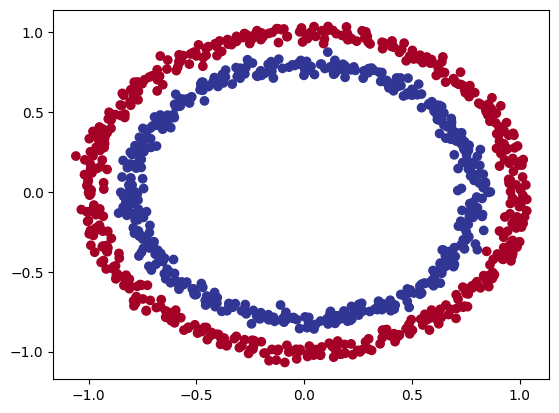

In [7]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

> 🛠 **Practice:** Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train. I think you'll find the data very similar to what we've just created.

## Input and output shapes


In our case, we want to input `X` and get our model to predict `y`.

So let's check out the shapes of `X` and `y`.

In [8]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

Hmm, where do these numbers come from?

In [9]:
# Check how many samples we have
len(X), len(y)

(1000, 1000)

So we've got as many `X` values as we do `y` values, that makes sense.

Let's check out one example of each.

In [10]:
# View the first example of features and labels
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`).

Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [11]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
history_1 = model_1.fit(X, y, epochs=5)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4456 - loss: 3.9274
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4592 - loss: 0.7798 
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4658 - loss: 0.7254 
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4652 - loss: 0.7082 
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4656 - loss: 0.7013 


Text(0.5, 1.0, 'Model_1 training curves')

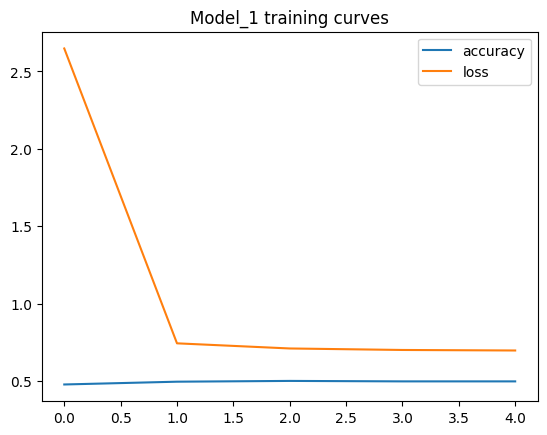

In [12]:
# Plot the loss curves
pd.DataFrame(history_1.history).plot()
plt.title("Model_1 training curves")

Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [14]:
# Train our model for longer (more chances to look at the data)
history_11 = model_1.fit(X, y, epochs=200, verbose=1) # set verbose=0 to remove training updates
model_1.evaluate(X, y)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4271 - loss: 0.6948 
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4271 - loss: 0.6948 
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4271 - loss: 0.6948 
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accura

[0.6932879686355591, 0.4729999899864197]

Text(0.5, 1.0, 'Model_1 training curves')

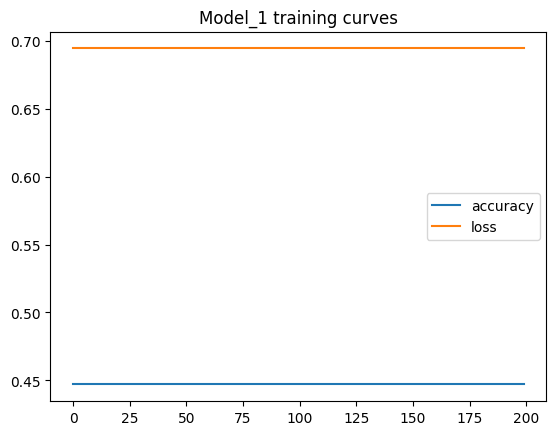

In [15]:
# Plot the loss curves
pd.DataFrame(history_11.history).plot()
plt.title("Model_1 training curves")

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [16]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (same as model_1 but with an extra layer)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # add an extra layer
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
history_2 = model_2.fit(X, y, epochs=100, verbose=1) # set verbose=0 to make the output print less

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4587 - loss: 4.0506
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4884 - loss: 0.7961 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4880 - loss: 0.7435 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4882 - loss: 0.7246 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4890 - loss: 0.7149 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4900 - loss: 0.7092 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4900 - loss: 0.7055 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4902 - loss: 0.7029 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4882 - loss: 0.7010 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4877 - loss: 0.6997 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4880 - loss: 0.6986 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

In [17]:
# Evaluate the model
model_2.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4955 - loss: 0.6934


[0.693218469619751, 0.5]

Text(0.5, 1.0, 'Model_1 training curves')

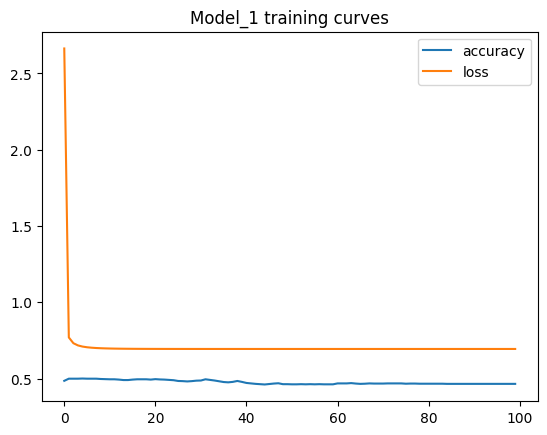

In [18]:
# Plot the loss curves
pd.DataFrame(history_2.history).plot()
plt.title("Model_1 training curves")

Still not even as good as guessing (~50% accuracy)... hmm...?

Let's remind ourselves of a couple more ways we can use to improve our models.

## Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function (such as the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, which is usually pretty good for many problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more epochs (leave it training for longer).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

How about we try adding more neurons, an extra layer and our friend the Adam optimizer?

Surely doing this will result in predictions better than guessing...

> **Note:** The following message (below this one) can be ignored if you're running TensorFlow 2.8.0+, the error seems to have been fixed.

> **Note:** If you're using TensorFlow 2.7.0+ (but not 2.8.0+) the original code from the following cells may have caused some errors. They've since been updated to fix those errors. You can see explanations on what happened at the following resources:
* [Example Colab Notebook](https://colab.research.google.com/drive/1_dlrB_DJOBS9c9foYJs49I0YwN7LTakl?usp=sharing)
* [TensorFlow for Deep Learning GitHub Discussion on TensorFlow 2.7.0 breaking changes](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278)


In [19]:
# How about we try adding more neurons, an extra layer and our friend the Adam optimizer?

In [20]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
model_3 = tf.keras.Sequential([
  # Before TensorFlow 2.7.0
  # tf.keras.layers.Dense(100), # add 100 dense neurons

  # With TensorFlow 2.7.0
  # tf.keras.layers.Dense(100, input_shape=(None, 1)), # add 100 dense neurons

  ## After TensorFlow 2.8.0 ##
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
history_3 = model_3.fit(X, y, epochs=100, verbose=1) # fit for 100 passes of the data

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.4541 - loss: 3.9126
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4629 - loss: 0.7101 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4937 - loss: 0.6970
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4371 - loss: 0.6986
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4682 - loss: 0.6991
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4565 - loss: 0.7000 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4591 - loss: 0.7007 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4606 - loss: 0.7013 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4558 - loss: 0.7018 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4486 - loss: 0.7023 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4430 - loss: 0.7027 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - a

Text(0.5, 1.0, 'Model_1 training curves')

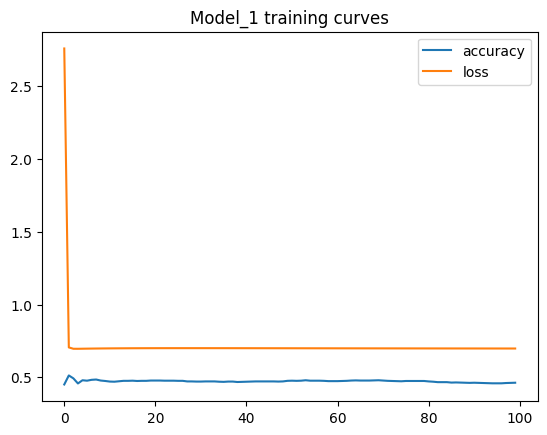

In [21]:
# Plot the loss curves
pd.DataFrame(history_3.history).plot()
plt.title("Model_1 training curves")

Still!

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualizations to see what's happening.

> 🔑 **Note:** Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: **visualize, visualize, visualize**. Inspect your data, inspect your model, inpsect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features (`X`) and labels (`y`).
* Creates a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

If this sounds confusing, let's see it in code and then see the output.

> 🔑 **Note:** If you're ever unsure of what a function does, try unraveling it and writing it line by line for yourself to see what it does. Break it into small parts and see what each part outputs.

In [22]:
import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classifcation...


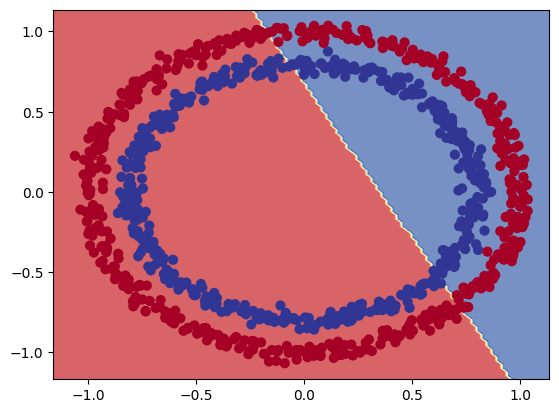

In [23]:
# Check out the predictions our model is making
plot_decision_boundary(model_3, X, y)

## The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and blue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

The main change we'll add to models we've built before is the use of the `activation` keyword.


In [24]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 hidden layer with linear activation
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # note: "lr" used to be what was used, now "learning_rate" is favoured
                metrics=["accuracy"])

# Fit the model
history_4 = model_4.fit(X, y, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4966 - loss: 6.1329
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4977 - loss: 6.0956   
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4970 - loss: 6.0811 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4970 - loss: 6.0746 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4951 - loss: 6.0655 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4990 - loss: 5.9987 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4964 - loss: 5.9389 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4964 - loss: 5.9230 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4964 - loss: 5.9047 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4994 - loss: 5.9219
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4983 - loss: 5.8881 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Okay, our model performs a little worse than guessing.

Let's remind ourselves what our data looks like.

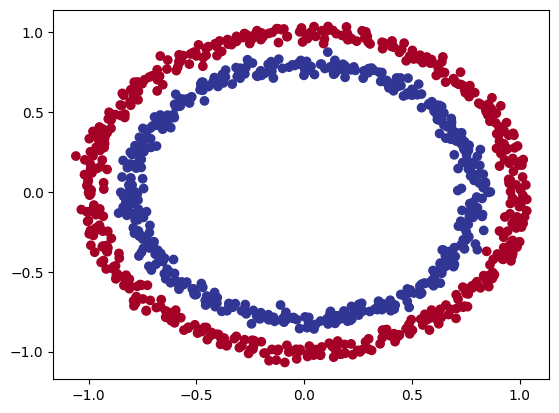

In [25]:
# Check out our data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

And let's see how our model is making predictions on it.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
doing binary classifcation...


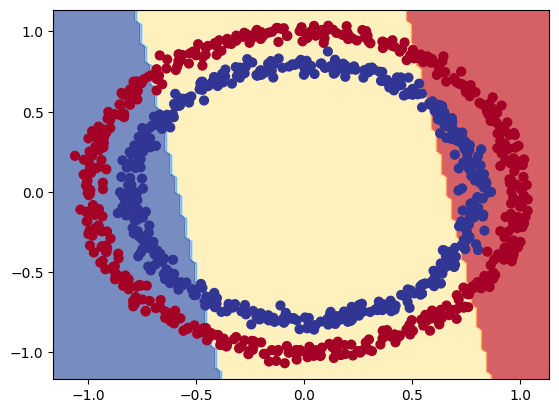

In [26]:
# Check the deicison boundary (blue is blue class, yellow is the crossover, red is red class)
plot_decision_boundary(model_4, X, y)

Well, it looks like we're getting a straight (linear) line prediction again.

But our data is non-linear (not a straight line)...

What we're going to have to do is add some non-linearity to our model.

To do so, we'll use the `activation` parameter in on of our layers.

In [27]:
# Set random seed
tf.random.set_seed(42)

# Create a model with a non-linear activation
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.relu), # can also do activation='relu'
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model_5.fit(X, y, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4558 - loss: 4.6491
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4629 - loss: 3.7537   
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4616 - loss: 3.6619 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4609 - loss: 3.5978 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4609 - loss: 3.5514 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4617 - loss: 3.5153 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4630 - loss: 3.4856 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4624 - loss: 3.4596 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4624 - loss: 3.4363 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4624 - loss: 3.4152
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4624 - loss: 3.3962 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Hmm... still not learning...

What we if increased the number of neurons and layers?

Say, 2 hidden layers, with [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu), pronounced "rel-u", (short for [rectified linear unit](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)), activation on the first one, and 4 neurons each?

To see this network in action, check out the [TensorFlow Playground demo](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).

![multi-layer neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-two-layer-net-relu-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).*

Let's try.

**Note:** in the course, Daniel used `lr` instead of `learning_rate`. But for the update, we had changed to `learning_rate` instead of `lr`.

In [28]:
# What we if increased the number of neurons and layers?
# Set random seed
tf.random.set_seed(42)

# Create a model
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, 4 neurons, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, 4 neurons, ReLU activation
  tf.keras.layers.Dense(1) # ouput layer
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam's default learning rate is 0.001
                metrics=['accuracy'])

# Fit the model
history = model_6.fit(X, y, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4614 - loss: 2.1790
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4614 - loss: 1.3389
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4600 - loss: 1.2135 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4610 - loss: 1.1354 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4603 - loss: 1.0779 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4570 - loss: 1.0307 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4477 - loss: 0.9903 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4451 - loss: 0.9556 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4248 - loss: 0.9254 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3916 - loss: 0.8990 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3747 - loss: 0.8757 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [29]:
# Evaluate the model
model_6.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7850 - loss: 0.4323


[0.42110735177993774, 0.7900000214576721]

We're still hitting 50% accuracy, our model is still practically as good as guessing.

How do the predictions look?

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classifcation...


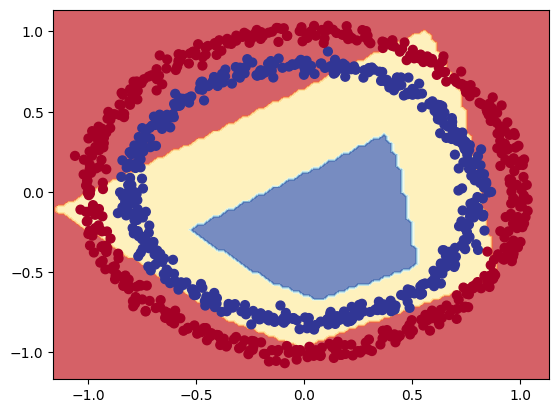

In [30]:
# Check out the predictions using 2 hidden layers
plot_decision_boundary(model_6, X, y)

In [31]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(X, y, epochs=100, verbose=0)

In [32]:
# Evaluate our model
model_7.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9414 - loss: 0.3151


[0.3149011731147766, 0.953000009059906]

Woah! It looks like our model is getting some incredible results, let's check them out.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classifcation...


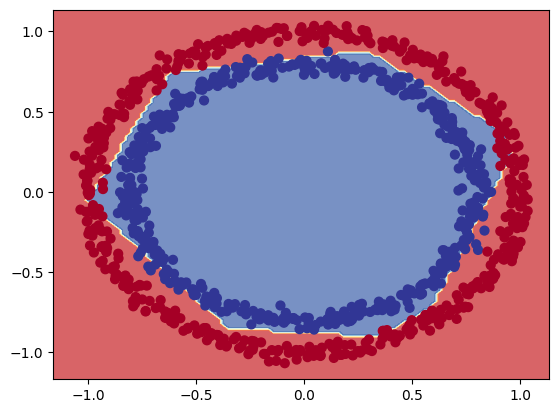

In [33]:
# View the predictions of the model with relu and sigmoid activations
plot_decision_boundary(model_7, X, y)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.



## Evaluating and improving our classification model

If you answered the question above, you might've picked up what we've been doing wrong.

We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

Let's do it.

In [34]:
# How many examples are in the whole dataset?
len(X)

1000

In [35]:
# Split data into train and test sets
X_train, y_train = X[:800], y[:800] # 80% of the data for the training set
X_test, y_test = X[800:], y[800:] # 20% of the data for the test set

# Check the shapes of the data
X_train.shape, X_test.shape # 800 examples in the training set, 200 examples in the test set

((800, 2), (200, 2))

Great, now we've got training and test sets, let's model the training data and evaluate what our model has learned on the test set.

In [38]:
# Set random seed
tf.random.set_seed(42)

# Create the model (same as model_7)
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1, using "relu" for activation (same as tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # output layer, using 'sigmoid' for the output
])

# Compile the model
model_8.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # increase learning rate from 0.001 to 0.01 for faster learning
                metrics=['accuracy'])

# Fit the model
history = model_8.fit(X_train, y_train, epochs=100)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4890 - loss: 0.7081
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5055 - loss: 0.6911 
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5216 - loss: 0.6854 
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5278 - loss: 0.6788 
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5521 - loss: 0.6699 
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5808 - loss: 0.6579 
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5986 - loss: 0.6447 
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6482 - loss: 0.6321 
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6731 - loss: 0.6158 
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6871 - loss: 0.6013 
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6854 - loss: 0.5881 
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [39]:
# Evaluate our model on the test set
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9841 - loss: 0.0416
Model loss on the test set: 0.050626520067453384
Model accuracy on the test set: 98.00%


100% accuracy? Nice!

Now, when we started to create `model_8` we said it was going to be the same as `model_7` but you might've found that to be a little lie.

That's because we changed a few things:
* **The `activation` parameter** - We used strings (`"relu"` & `"sigmoid"`) instead of using library paths (`tf.keras.activations.relu`), in TensorFlow, they both offer the same functionality.
* **The `learning_rate` (also `lr`) parameter** - We increased the **learning rate** parameter in the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) to `0.01` instead of `0.001` (an increase of 10x).

* **The number of epochs** - We lowered the number of epochs (using the `epochs` parameter) from 100 to 25 but our model still got an incredible result on both the training and test sets.
  * One of the reasons our model performed well in even less epochs (remember a single epoch is the model trying to learn patterns in the data by looking at it once, so 25 epochs means the model gets 25 chances) than before is because we increased the learning rate.

We know our model is performing well based on the evaluation metrics but let's see how it performs visually.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
doing binary classifcation...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...


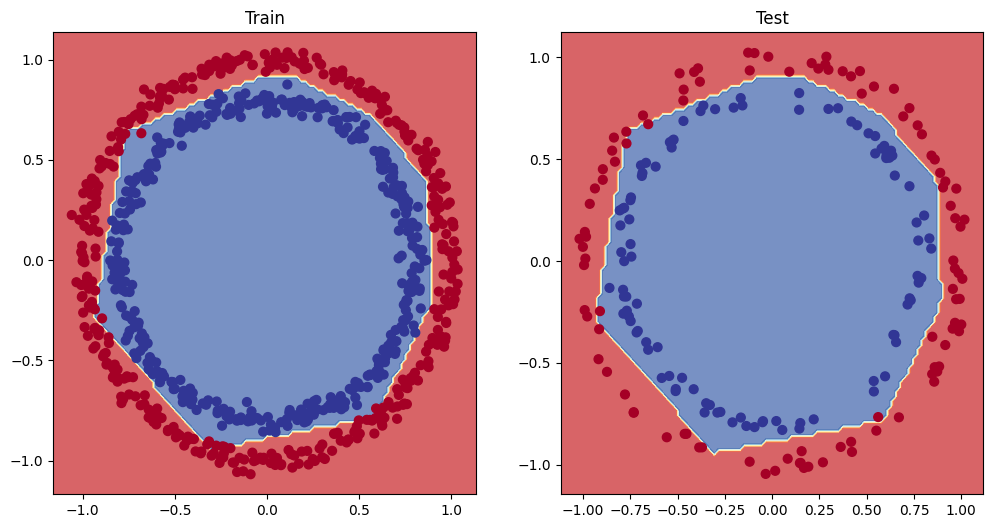

In [40]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X=X_test, y=y_test)
plt.show()

Check that out! How cool. With a few tweaks, our model is now predicting the blue and red circles almost perfectly.

### Plot the loss curves



As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

To figure this out, we can check the **loss curves** (also referred to as the **learning curves**).

You might've seen we've been using the variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).


In [41]:
# You can access the information in the history variable using the .history attribute
pd.DataFrame(history.history)

,accuracy,loss
0,0.48000,0.703710
1,0.51375,0.687625
2,0.53500,0.679881
3,0.55375,0.671526
4,0.59125,0.660725
...,...,...
95,0.99125,0.043515
96,0.99125,0.042750
97,0.99125,0.041954
98,0.99125,0.041459


Inspecting the outputs, we can see the loss values going down and the accuracy going up.

How's it look (visualize, visualize, visualize)?

Text(0.5, 1.0, 'Model_8 training curves')

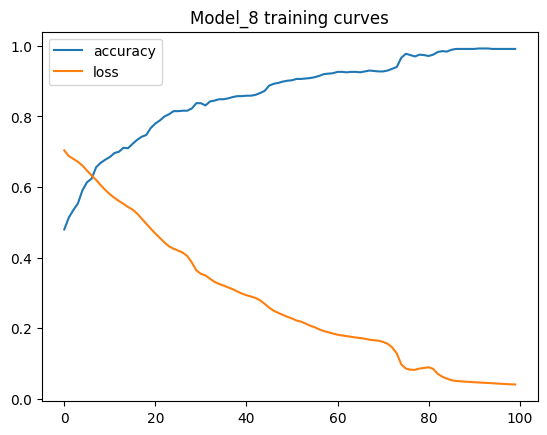

In [42]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_8 training curves")

Beautiful. This is the ideal plot we'd be looking for when dealing with a classification problem, loss going down, accuracy going up.

> 🔑 **Note:** For many problems, the loss function going down means the model is improving (the predictions it's making are getting closer to the ground truth labels).

## Working with a larger example (multiclass classification)

We've seen a binary classification example (predicting if a data point is part of a red circle or blue circle) but what if you had multiple different classes of things?

For example, say you were a fashion company and you wanted to build a neural network to predict whether a piece of clothing was a shoe, a shirt or a jacket (3 different options).

When you have more than two classes as an option, this is known as **multiclass classification**.

The good news is, the things we've learned so far (with a few tweaks) can be applied to multiclass classification problems as well.

Let's see it in action.

To start, we'll need some data. The good thing for us is TensorFlow has a multiclass classication dataset known as [Fashion MNIST built-in](https://github.com/zalandoresearch/fashion-mnist). Meaning we can get started straight away.

We can import it using the [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) module.

> 📖 **Resource:** The following multiclass classification problem has been adapted from the [TensorFlow classification guide](https://www.tensorflow.org/tutorials/keras/classification). A good exercise would be to once you've gone through the following example, replicate the TensorFlow guide.

In [43]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Now let's check out an example.

In [44]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n")
print(f"Training label: {train_labels[0]}")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

Woah, we get a large list of numbers, followed (the data) by a single number (the class label).

What about the shapes?

In [45]:
# Check the shape of our data
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [47]:
# Check shape of a single example
train_data[0].shape

(28, 28)

Okay, 60,000 training examples each with shape (28, 28) and a label each as well as 10,000 test examples of shape (28, 28).

But these are just numbers, let's visualize.

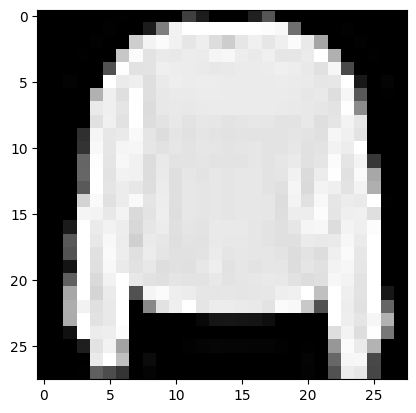

In [48]:
# Plot a single example
import matplotlib.pyplot as plt
plt.imshow(train_data[7],cmap = 'gray');

Hmm, but what about its label?

In [49]:
# Check our samples label
train_labels[7]

2

It looks like our labels are in numerical form. And while this is fine for a neural network, you might want to have them in human readable form.

Let's create a small list of the class names (we can find them on [the dataset's GitHub page](https://github.com/zalandoresearch/fashion-mnist#labels)).

> 🔑 **Note:** Whilst this dataset has been prepared for us and ready to go, it's important to remember many datasets won't be ready to go like this one. Often you'll have to do a few preprocessing steps to have it ready to use with a neural network (we'll see more of this when we work with our own data later).

In [50]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# How many classes are there (this'll be our output shape)?
len(class_names)

10

Now we have these, let's plot another example.

> 🤔 **Question:** Pay particular attention to what the data we're working with *looks* like. Is it only straight lines? Or does it have non-straight lines as well? Do you think if we wanted to find patterns in the photos of clothes (which are actually collections of pixels), will our model need non-linearities (non-straight lines) or not?

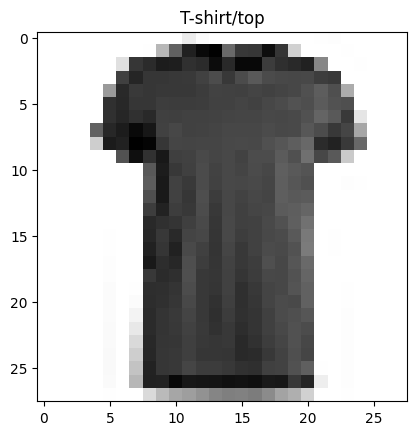

In [51]:
# Plot an example image and its label
plt.imshow(train_data[17], cmap=plt.cm.binary) # change the colours to black & white
plt.title(class_names[train_labels[17]]);

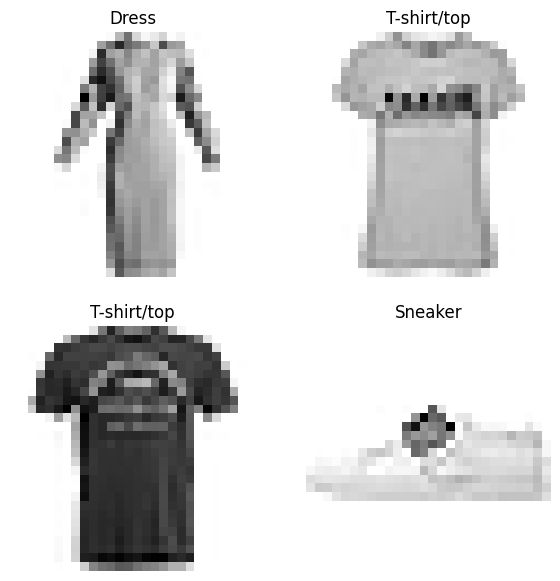

In [52]:
# Plot multiple random images of fashion MNIST
import random
plt.figure(figsize=(7, 7))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_index]])
  plt.axis(False)

Alright, let's build a model to figure out the relationship between the pixel values and their labels.

Since this is a multiclass classification problem, we'll need to make a few changes to our architecture (inline with Table 1 above):

* The **input shape** will have to deal with 28x28 tensors (the height and width of our images).
  * We're actually going to squash the input into a tensor (vector) of shape `(784)`.
* The **output shape** will have to be 10 because we need our model to predict for 10 different classes.
  * We'll also change the `activation` parameter of our output layer to be [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) instead of `'sigmoid'`. As we'll see the `"softmax"` activation function outputs a series of values between 0 & 1 (the same shape as **output shape**, which together add up to ~1. The index with the highest value is predicted by the model to be the most *likely* class.
* We'll need to change our loss function from a binary loss function to a multiclass loss function.
  * More specifically, since our labels are in integer form, we'll use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), if our labels were one-hot encoded (e.g. they looked something like `[0, 0, 1, 0, 0...]`), we'd use [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).
* We'll also use the `validation_data` parameter when calling the `fit()` function. This will give us an idea of how the model performs on the test set during training.

You ready? Let's go.

In [53]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_11 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784, the Flatten layer does this for us)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_11.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # different loss function for multiclass classifcation
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model
non_norm_history = model_11.fit(train_data,
                                train_labels,
                                epochs=10,
                                validation_data=(test_data, test_labels)) # see how the model performs on the test set during training

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1043 - loss: 2.5903 - val_accuracy: 0.1063 - val_loss: 2.2880
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1265 - loss: 2.2381 - val_accuracy: 0.2468 - val_loss: 1.7879
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2708 - loss: 1.7468 - val_accuracy: 0.3130 - val_loss: 1.6393
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3196 - loss: 1.6344 - val_accuracy: 0.3709 - val_loss: 1.5356
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3510 - loss: 1.5590 - val_accuracy: 0.3623 - val_loss: 1.5024
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3737 - loss: 1.4870 - val_accuracy: 0.3861 - val_loss: 1.4465
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3972 - loss: 1.4237 - val_accuracy: 0.4042 - val_loss: 1.4058
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4065 - loss: 1.3979 - 

In [54]:
# Check the shapes of our model
# Note: the "None" in (None, 784) is for batch_size, we'll cover this in a later module
model_11.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 4)                   │           3,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 10)                  │              50 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,632 (37.63 KB)

 Trainable params: 3,210 (12.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,422 (25.09 KB)

Alright, our model gets to about ~35% accuracy after 10 epochs using a similar style model to what we used on our binary classification problem.

Which is better than guessing (guessing with 10 classes would result in about 10% accuracy) but we can do better.

Do you remember when we talked about neural networks preferring numbers between 0 and 1? (if not, treat this as a reminder)

Well, right now, the data we have isn't between 0 and 1, in other words, it's not normalized (hence why we used the `non_norm_history` variable when calling `fit()`). It's pixel values are between 0 and 255.

Let's see.

In [55]:
# Check the min and max values of the training data
train_data.min(), train_data.max()

(0, 255)

We can get these values between 0 and 1 by dividing the entire array by the maximum: `255.0` (dividing by a float also converts to a float).


Doing so will result in all of our data being between 0 and 1 (known as **scaling** or **normalization**).

In [56]:
# Divide train and test images by the maximum value (normalize it)
train_data = train_data / 255.0
test_data = test_data / 255.0

# Check the min and max values of the training data
train_data.min(), train_data.max()

(0.0, 1.0)

Beautiful! Now our data is between 0 and 1. Let's see what happens when we model it.

We'll use the same model as before (`model_11`) except this time the data will be normalized.

In [57]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_12 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_12.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model (to the normalized data)
norm_history = model_12.fit(train_data,
                            train_labels,
                            epochs=10,
                            validation_data=(test_data, test_labels))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4192 - loss: 1.3848 - val_accuracy: 0.7406 - val_loss: 0.7175
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7537 - loss: 0.6820 - val_accuracy: 0.7629 - val_loss: 0.6590
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7739 - loss: 0.6321 - val_accuracy: 0.7857 - val_loss: 0.6199
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7921 - loss: 0.5912 - val_accuracy: 0.7958 - val_loss: 0.5949
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8029 - loss: 0.5693 - val_accuracy: 0.7992 - val_loss: 0.5837
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8073 - loss: 0.5568 - val_accuracy: 0.8031 - val_loss: 0.5764
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8104 - loss: 0.5479 - val_accuracy: 0.8054 - val_loss: 0.5705
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8128 - loss: 0.5408 - 

Woah, we used the exact same model as before but we with normalized data we're now seeing a much higher accuracy value!

Let's plot each model's history (their loss curves).

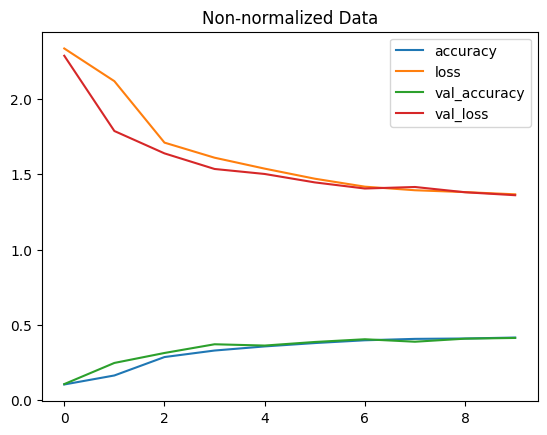

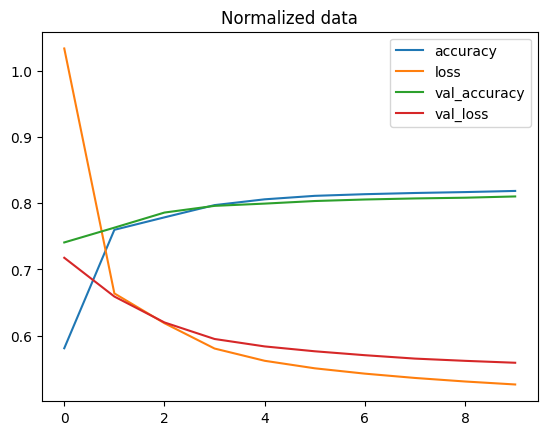

In [58]:
import pandas as pd
# Plot non-normalized data loss curves
pd.DataFrame(non_norm_history.history).plot(title="Non-normalized Data")
# Plot normalized data loss curves
pd.DataFrame(norm_history.history).plot(title="Normalized data");

Wow. From these two plots, we can see how much quicker our model with the normalized data (`model_12`) improved than the model with the non-normalized data (`model_11`).

> 🔑 **Note:** The same model with even *slightly* different data can produce *dramatically* different results. So when you're comparing models, it's important to make sure you're comparing them on the same criteria (e.g. same architecture but different data or same data but different architecture).


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5784 - loss: 0.6884 - val_accuracy: 0.7522 - val_loss: 0.6376
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7658 - loss: 0.5981 - val_accuracy: 0.8252 - val_loss: 0.4679
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8389 - loss: 0.4314 - val_accuracy: 0.8512 - val_loss: 0.3711
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8705 - loss: 0.3404 - val_accuracy: 0.8698 - val_loss: 0.3278
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8862 - loss: 0.2955 - val_accuracy: 0.8778 - val_loss: 0.3061
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8968 - loss: 0.2662 - val_accuracy: 0.8826 - val_loss: 0.2937
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9054 - loss: 0.2443 - val_accuracy: 0.8850 - val_loss: 0.2866
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9134 - loss: 0.2264 - val_accuracy: 0.8854 - val

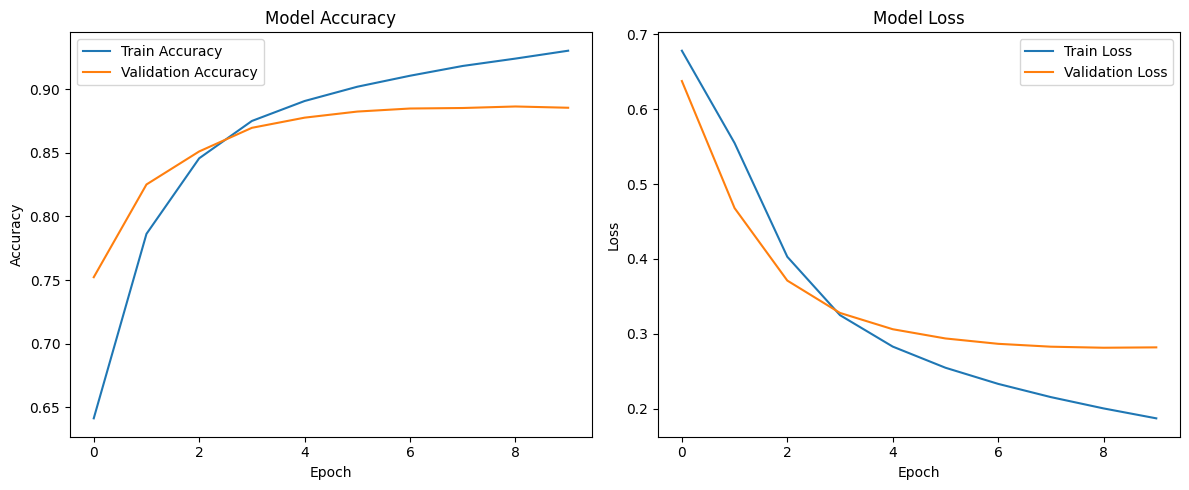


Custom Review Predictions:
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Positive Review Sentiment: 0.5488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Negative Review Sentiment: 0.6746
